In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
def get_time(filename):
    values = filename.split("_")
    for t_value in values:
        if t_value in ['2','4','6','8','10','12']:
            # print(t_value)
            return int(t_value)
    return None

In [3]:
features_col = ['Arflux1','Arflux2','Arflux3','Arflux4','Arflux5','Arflux6',
            'Fflux1','Fflux2','Fflux3','Fflux4','Fflux5','Fflux6',
            'ArExponent','FrExponent',
            'yield_at_zero1','yield_at_zero2','yield_at_zero3',
            'yield_max1','yield_max2','yield_max3',
            'theta_max1','theta_max2','theta_max3','mizk',
            'p1','p2','p3','p4','p5']

In [55]:
df_final = pd.DataFrame()
# valid_df_final = pd.DataFrame()
test_df_final = pd.DataFrame()

test_file_num = 0
turn = 0

for folder in os.listdir('C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_time_changing_flux/csvfiles'):

    if turn==1: test_file_num+=6
    
    input_values = folder.split('_')[1:]
    input_values = [float(item) for item in input_values]

    # sorting file acc to len so that t= 10,12 gets to its original pos
    for file in sorted(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_time_changing_flux/csvfiles/{folder}'), key=len):

        if(turn == 0 or test_file_num>300):
            df = pd.read_csv(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_time_changing_flux/csvfiles/{folder}/{file}')

        #dropping rows with zero valies in it
            zero_values_row_index = df[df['FitRadius_Avg']==0].index
            df = df.drop(zero_values_row_index)

        #just for getting depth
            new_col_names = ['Z','avg fitradius', 'time']
            new_row_values =  [-df['Z'].iloc[0], df['FitRadius_Avg'].mean(), get_time(file)]
            new_df = pd.DataFrame([new_row_values],columns=new_col_names)

            for i in range(29):
                # print(features_col[i], input_values[i])
                new_df[features_col[i]] = input_values[i]
            df_final = pd.concat([df_final,new_df])   

        # elif file_num<2406:
        #     df = pd.read_csv(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_time_changing_flux/csvfiles/{folder}/{file}')
        #     zero_values_row_index = df[df['FitRadius_Avg']==0].index
        #     df = df.drop(zero_values_row_index)

        # #just for getting depth
        #     new_col_names = ['Z','avg fitradius', 'time']
        #     new_row_values =  [-df['Z'].iloc[0], df['FitRadius_Avg'].mean(), get_time(file)]
        #     new_df = pd.DataFrame([new_row_values],columns=new_col_names)

        #     for i in range(29):
        #         # print(features_col[i], input_values[i])
        #         new_df[features_col[i]] = input_values[i]
        #     valid_df_final = pd.concat([valid_df_final,new_df])

        else:

            test_df = pd.read_csv(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_time_changing_flux/csvfiles/{folder}/{file}')

        #dropping rows with zero valies in it
            zero_values_row_index = test_df[test_df['FitRadius_Avg']==0].index
            test_df = test_df.drop(zero_values_row_index)

        #just for getting depth
            new_col_names = ['Z','avg fitradius', 'time']
            new_row_values =  [-test_df['Z'].iloc[0], test_df['FitRadius_Avg'].mean(), get_time(file)]
            new_df = pd.DataFrame([new_row_values],columns=new_col_names)

            for i in range(29):
                # print(features_col[i], input_values[i])
                new_df[features_col[i]] = input_values[i]
            test_df_final = pd.concat([test_df_final,new_df])    
    turn = 1 - turn

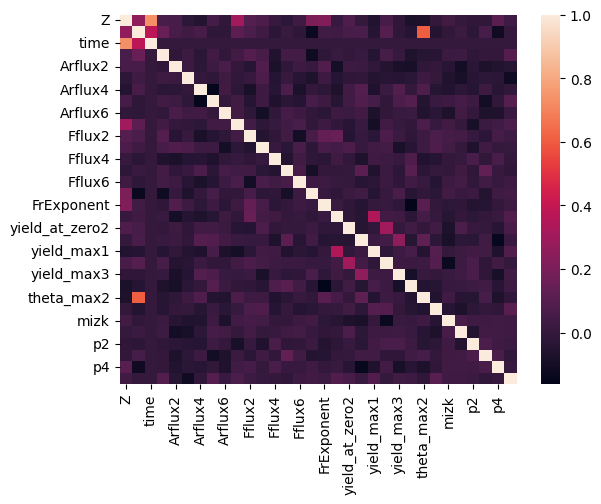

In [56]:
corr = df_final.corr()
heatmap_corr = sns.heatmap(corr)

In [57]:
x_train = df_final.loc[:, ~df_final.columns.isin(['Z','avg fitradius'])]
y_train = df_final[['Z']]
# x_valid = valid_df_final.loc[:, ~valid_df_final.columns.isin(['Z','avg fitradius'])]
# y_valid = valid_df_final[['Z']]
y_test = test_df_final[['Z']]
x_test = test_df_final.drop(['Z','avg fitradius'], axis=1)

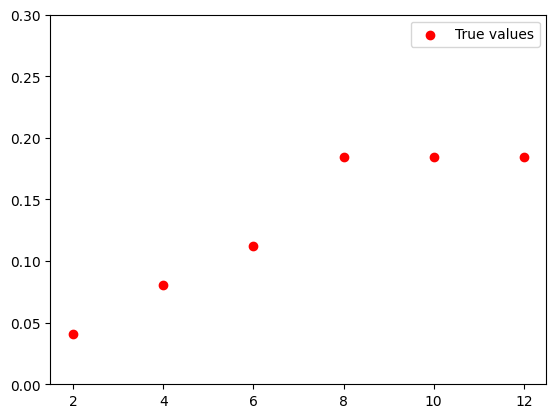

In [58]:
plt.ylim(0, 0.3)
plt.scatter(x_test.iloc[6:12,0],y_test.iloc[6:12,0],c='red',label=f'True values')
plt.legend()

In [461]:
y_train_scale = y_train*10000
y_test_scale = y_test*10000

In [85]:
from tensorflow.keras import backend as K

def relative_mean_absolute_error(y_true, y_pred):
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate Mean Absolute Error (MAE)
    rmae = np.abs(y_true - y_pred)
    rmae = np.mean(rmae/y_true)
    
    return rmae

def custom_mae(y_true, y_pred):
    return relative_mean_absolute_error(y_true, y_pred)

def custom_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [544]:
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler_x_train = StandardScaler()
X_scale_arr = scaler_x_train.fit_transform(x_train)
df_scaledX = pd.DataFrame(X_scale_arr, columns=x_train.columns)

# scaler_y_train = StandardScaler()
# y_scale_arr = scaler_y_train.fit_transform(y_train)
# df_scaledy = pd.DataFrame(y_scale_arr, columns=y_train.columns)

# scaler_x_valid = StandardScaler()
# X_scale_v_arr = scaler_x_valid.fit_transform(x_valid)
# df_scaledX_v = pd.DataFrame(X_scale_v_arr, columns=x_test.columns)

# scaler_y_valid = StandardScaler()
# y_scale_v_arr = scaler_y_valid.fit_transform(y_valid)
# df_scaledy_v = pd.DataFrame(y_scale_v_arr, columns=y_test.columns)

scaler_x_test = StandardScaler()
X_scale_t_arr = scaler_x_test.fit_transform(x_test)
df_scaledX_t = pd.DataFrame(X_scale_t_arr, columns=x_test.columns)

# scaler_y_test = StandardScaler()
# y_scale_t_arr = scaler_y_test.fit_transform(y_test)
# df_scaledy_t = pd.DataFrame(y_scale_t_arr, columns=y_test.columns)


X_train_scaled_reshaped = X_scale_arr.reshape(X_scale_arr.shape[0],1,X_scale_arr.shape[1])
X_train_scaled_reshaped.shape

X_test_scaled_reshaped = X_scale_t_arr.reshape(X_scale_t_arr.shape[0],1,X_scale_t_arr.shape[1])
X_test_scaled_reshaped.shape

# X_valid_scaled_reshaped = X_scale_v_arr.reshape(X_scale_v_arr.shape[0],1,X_scale_v_arr.shape[1])
# X_valid_scaled_reshaped.shape

(300, 1, 30)

Changing time steps

In [341]:
X_train_scaled_reshaped = X_scale_arr.reshape(int(X_scale_arr.shape[0]/6),6,X_scale_arr.shape[1])
X_train_scaled_reshaped.shape

X_test_scaled_reshaped = X_scale_t_arr.reshape(int(X_scale_t_arr.shape[0]/6),6,X_scale_t_arr.shape[1])
X_test_scaled_reshaped.shape

y_scale_arr_reshaped = y_train_scale.to_numpy().reshape(int(y_train_scale.shape[0]/6),6,y_train_scale.shape[1])
y_scale_t_arr_reshaped = y_test_scale.to_numpy().reshape(int(y_test_scale.shape[0]/6),6,y_test_scale.shape[1])
y_scale_arr_reshaped.shape

(450, 6, 1)

In [62]:
# X_df = pd.concat([df_scaledX,df_scaledX_t])
# y_df = pd.concat([df_scaledy,df_scaledy_t])

Random Forest Regressor (Ensemble method)

Using K-fold cross validation

In [63]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import KFold, cross_validate

# def custom_mse(y_true, y_pred):
#     return mean_absolute_error(y_true, y_pred)

# def custom_r2(y_true, y_pred):
#     return r2_score(y_true, y_pred)

# mse_scorer = make_scorer(custom_mse, greater_is_better=False)
# r2_scorer = make_scorer(custom_r2)

# #if using k fold validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# model = RandomForestRegressor(n_estimators=200, random_state=42)

# ##Cross-validation (automatic)

# cv_results = cross_validate(
#     model,X_df , y_df, cv=kf, scoring={'mse': mse_scorer, 'r2': r2_scorer}, return_train_score=True
# )
# print("Cross-Validation MSE:", -cv_results['test_mse'].mean())
# print("Cross-Validation R^2:", cv_results['test_r2'].mean())
# print("\nDetailed Cross-Validation Results:")
# print(pd.DataFrame(cv_results))

Without k-fold

In [64]:
# # Without K-fold Cross validation

# from sklearn.ensemble import RandomForestRegressor

# #after certain value, no of trees doesn't matter
# model = RandomForestRegressor(n_estimators=200, random_state=42)

# model.fit(X_train_scaled_reshaped.reshape(X_train_scaled_reshaped.shape[0], X_train_scaled_reshaped.shape[2]), y_scale_arr.ravel())
# y_pred = model.predict(X_test_scaled_reshaped.reshape(X_test_scaled_reshaped.shape[0], X_test_scaled_reshaped.shape[2]))

# # Evaluate the model
# mse = abs(custom_mae(y_scale_t_arr,y_pred))
# r2 = custom_r2(y_scale_t_arr,y_pred)

# print("RMAE:", mse)
# print("R^2 Score:", r2)

# # Detailed R^2 Score for each target
# # r2_individual = r2_score(y_train, y_pred, multioutput='raw_values')
# # print("R^2 Score for each target:", r2_individual)

In [65]:
# predictions = scaler_y_test.inverse_transform(y_pred.reshape(-1,1))
# x_test_plot = scaler_x_test.inverse_transform(X_test_scaled_reshaped.reshape(X_test_scaled_reshaped.shape[0],X_test_scaled_reshaped.shape[2]))

In [66]:
# for i in range(6*5,6*15,6):
#     # plt.clf()
#     # clear_output(wait=True)
#     plt.figure()
#     plt.xlim(1,13)
#     # plt.ylim(0,0.3)
#     plt.title(f'Graph {i/6}')
#     plt.xlabel('Time')
#     plt.ylabel('Depth')
#     plt.scatter(x_test.iloc[i-6:i,0],y_test.iloc[i-6:i,0],c='red',label=f'True values')
#     plt.scatter(x_test_plot[i-6:i,0],predictions[i-6:i,0],c='blue',label=f'Predicted values')
#     plt.show()
#     plt.cla()
#     plt.clf()
#     plt.close()

In [67]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,6))

# plt.scatter(x_test.iloc[6:12,0],y_test.iloc[6:12,0],c='red',label=f'True values')
# # plt.plot(x_test.iloc[6:12,0],y_test.iloc[6:12,0], 'r--')
# plt.scatter(x_test_plot[6:12,0],predictions[6:12,0],linestyle='-',c='blue',label=f'Predicted values')
# # plt.plot(x_test_plot[6:12,0],predictions[6:12,0], 'b--')

# plt.legend()
# plt.show()


In [540]:
#Fully Conn. ANN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D
from tensorflow.keras.callbacks import EarlyStopping

def custom_loss_function(y_true, y_pred):
    error = K.abs(y_true - y_pred)
    error = error / y_true
    loss = K.mean(error)
    return loss

def create_ann_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    # model.add(Conv1D(filters=1, kernel_size=6, data_format="channels_first", activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    # model.add(Dropout(0.4))    
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.3))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))  # Assuming 1 target variable
    model.compile(optimizer='adam', loss='mape')
    return model

# Assuming X_train_scaled_reshaped and X_test_scaled_reshaped are 2D arrays
# and the input shape is the number of features
input_shape = (X_scale_arr.shape[1])

model = create_ann_model(input_shape=input_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001, verbose=1)

history = model.fit(X_scale_arr, y_train_scale, epochs=500, batch_size=16, verbose=1, 
                    validation_data=(X_scale_t_arr, y_test_scale), 
                    # callbacks=[early_stopping]
                    )

# Predict on the test set
y_pred = model.predict(X_scale_t_arr)

print(f'Loss:{relative_mean_absolute_error(y_test_scale, y_pred)}')

Epoch 1/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 62.2657 - val_loss: 28.4114
Epoch 2/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 26.0584 - val_loss: 25.2263
Epoch 3/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 22.1477 - val_loss: 22.0926
Epoch 4/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.3232 - val_loss: 25.8944
Epoch 5/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 19.4894 - val_loss: 22.6640
Epoch 6/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.2918 - val_loss: 23.9110
Epoch 7/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.3585 - val_loss: 28.8643
Epoch 8/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 17.4729 - val_loss: 24.8766
Epoch 9/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 16.2500 - val_loss: 23.5944
Epoch 10/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 16.7892 - val_loss: 30.8623
Epoch 11/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.8116 - val_loss: 26.7273
Epoch 12/500
169/1

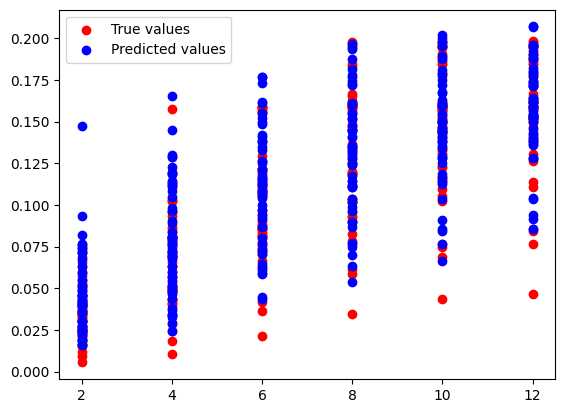

In [541]:
# predictions = scaler_y_test.inverse_transform(y_pred.reshape(-1,1))
# x_test_plot = scaler_x_test.inverse_transform(X_test_scaled_reshaped.reshape(X_test_scaled_reshaped.shape[0],30))

plt.scatter(x_test.iloc[:,0],y_test.iloc[:,0],c='red',label=f'True values')
plt.scatter(x_test.iloc[:,0],y_pred[:,0]/10000,c='blue',label=f'Predicted values')
plt.legend()

In [555]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

def create_rnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(SimpleRNN(1024, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(512, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(256, return_sequences=True, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(SimpleRNN(128, return_sequences=True, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(SimpleRNN(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))  # Assuming 1 target variable
    model.compile(optimizer='adam', loss='mape')
    return model

# Assuming X_train_scaled_reshaped and X_test_scaled_reshaped are 3D arrays
# and the input shape is (time_steps, number of features)
input_shape = (X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2])

model = create_rnn_model(input_shape=input_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001, verbose=1)

history = model.fit(X_train_scaled_reshaped, y_train_scale, epochs=500, batch_size=16, verbose=1, 
                    validation_data=(X_test_scaled_reshaped, y_test_scale), 
                    # callbacks=[early_stopping]
                    )

# Predict on the test set
y_pred = model.predict(X_test_scaled_reshaped)

print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')


Epoch 1/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 65.1258 - val_loss: 26.9062
Epoch 2/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 25.5012 - val_loss: 27.3318
Epoch 3/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 21.6213 - val_loss: 29.5660
Epoch 4/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 20.6910 - val_loss: 27.2586
Epoch 5/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 18.6403 - val_loss: 25.6054
Epoch 6/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 18.4158 - val_loss: 31.6815
Epoch 7/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 17.2687 - val_loss: 32.5179
Epoch 8/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 18.0056 - val_loss: 24.1941
Epoch 9/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 16.2824 - val_loss: 21.9479
Epoch 10/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 16.5943 - val_loss: 30.0563
Epoch 11/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 16.4253 - val_loss: 25.3395
Epoch 1

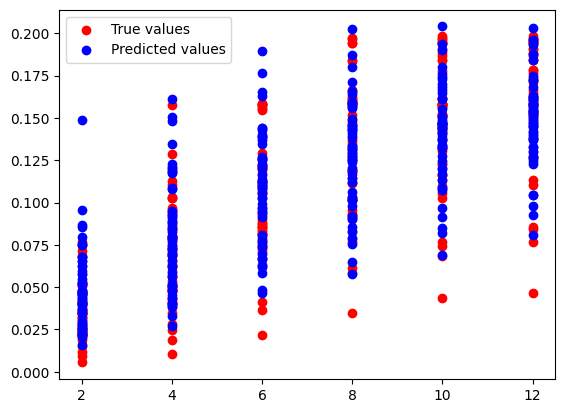

In [557]:
plt.scatter(x_test.iloc[:,0],y_test.iloc[:,0],c='red',label=f'True values')
plt.scatter(x_test.iloc[:,0],y_pred[:,0]/10000,c='blue',label=f'Predicted values')
plt.legend()

LSTM model

In [384]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input, Dropout
from keras.callbacks import EarlyStopping


def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))    
    # model.add(Dense(200))
    # model.add(LSTM(512, dropout=0.5, return_sequences=True, activation='relu'))
    # model.add(LSTM(256,  dropout=0.4, return_sequences=True, activation='relu'))
    model.add(LSTM(200, dropout=0.3, return_sequences=True, activation='relu'))
    model.add(LSTM(100, dropout=0.3, return_sequences=True, activation='relu'))
    model.add(LSTM(50, dropout=0.2, return_sequences=True, activation='relu'))
    model.add(LSTM(25, dropout=0.2, activation='relu'))
    model.add(Dense(1))  # Assuming 2 target variables
    model.compile(optimizer='adam', loss='mape')
    return model

# Build and train the model

model = create_lstm_model(input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001, verbose=1)
history = model.fit(X_train_scaled_reshaped, y_scale_arr_reshaped, epochs=1000, batch_size=16, verbose=1, validation_data=(X_test_scaled_reshaped, y_scale_t_arr_reshaped), 
                    callbacks=[early_stopping]
                    )

# val_loss = model.evaluate(X_valid_scaled_reshaped,y_scale_v_arr)
# print(f'Validation Loss: {val_loss}')

# Predict on the test set
y_pred = model.predict(X_test_scaled_reshaped)

Epoch 1/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 99.9998 - val_loss: 99.9410
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 91.4194 - val_loss: 63.9149
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 59.4686 - val_loss: 55.2629
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 52.1275 - val_loss: 54.7221
Epoch 10/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 52.2681 - val_loss: 54.0007
Epoch 11/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 50.0455 - val_loss: 51.6259
Epoch 12

In [ ]:
# x_test_plot = scaler_x_test.inverse_transform(X_test_scaled_reshaped.reshape(X_test_scaled_reshaped.shape[0],30))

plt.scatter(x_test.iloc[5::6,0], y_scale_t_arr_reshaped[:,5,0]/1000,c='red',label=f'True values')
plt.scatter(x_test.iloc[5::6,0],y_pred[:,0]/1000,c='blue',label=f'Predicted values')
plt.legend()

In [18]:
# Evaluate the model
# mae = custom_mae(y_scale_t_arr, y_pred)
# r2_score_c= custom_r2(y_scale_t_arr, y_pred)

# print("Relative Mean Abs Error (MAE):", mae)
# print("R2 score: ", r2_score_c)

In [19]:
# predictions = scaler_y_test.inverse_transform(y_pred)
# x_test_plot = scaler_x_test.inverse_transform(X_test_scaled_reshaped.reshape(X_test_scaled_reshaped.shape[0],30))

plot of CD(fit radius) vs Z for true and predicted

In [20]:
# plt.figure(figsize=(10,6))

# plt.scatter(y_test.iloc[:6,0],y_test.iloc[:6,1],c='red',label=f'True values')
# plt.plot(y_test.iloc[:6,0],y_test.iloc[:6,1],'r--')
# plt.scatter(predictions[:6,0],predictions[:6,1],linestyle='-',c='blue',label=f'Predicted values')
# # plt.plot(x_test_plot[:6,0],predictions[:6,0],'b--')
# plt.ylim(0,0.4)
# # plt.legend()

# plt.legend()
# # plt.show()


plot of true value and predicted value

In [21]:
# for i in range(6*5,6*15,6):
#     # plt.clf()
#     # clear_output(wait=True)
#     plt.figure()
#     plt.xlim(0,13)
#     plt.ylim(0,0.5)
#     plt.title(f'Graph {i/6}')
#     plt.xlabel('Time')
#     plt.ylabel('Depth')
#     plt.scatter(x_test.iloc[i-6:i,0],y_test.iloc[i-6:i,0],c='red',label=f'True values')
#     plt.scatter(x_test_plot[i-6:i,0],predictions[i-6:i,0],c='blue',label=f'Predicted values')
#     plt.show()
#     plt.cla()
#     plt.clf()
#     plt.close()
   

In [22]:
# predictions_df = pd.DataFrame(predictions, columns=['Z'])
# predictions_df.head(12)

In [23]:
# plt.scatter(x_test.iloc[:,0],y_test.iloc[:,0],c='red',label=f'True values')
# plt.scatter(x_test_plot[:,0],predictions[:,0],linestyle='-',c='blue',label=f'Predicted values')
# plt.legend()

SARIMA model (only for univariate models, so can't be used here)

GMM

In [24]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=6, max_iter=50)
# x_train_clusters = gmm.fit_predict(x_train)

# gmm_test = GaussianMixture(n_components=6, max_iter=50)
# x_test_clusters = gmm.fit_predict(x_test)

In [25]:
# plt.plot(x_train_clusters)

In [26]:
# X_cluster_df = pd.DataFrame(np.concatenate())

GNNs using spektal gnn instead of tf gnn

In [27]:
# import numpy as np
# import tensorflow as tf
# from spektral.data import Dataset, Graph
# from spektral.layers import GCNConv, GlobalAvgPool, GlobalMaxPool
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense

# # Assuming X_train_scaled_reshaped, X_test_scaled_reshaped, y_scale_arr, and y_test are available and formatted as required

# # Sample data preparation
# num_nodes = X_train_scaled_reshaped.shape[1]
# num_features = X_train_scaled_reshaped.shape[2]
# num_classes = y_scale_arr.shape[1]

# # Generate adjacency matrix (modify to reflect your actual graph structure)
# # This is a simple example, consider using a sparse matrix for larger graphs
# #so using zeroes instead of ones
# A = np.zeros((num_nodes, num_nodes)) + np.eye(num_nodes)

# # Define a custom Spektral dataset
# class MyDataset(Dataset):
#     def __init__(self, X, A, y, **kwargs):
#         self.X = X
#         self.A = A
#         self.y = y
#         super().__init__(**kwargs)

#     def read(self):
#         graphs = []
#         for i in range(len(self.X)):
#             x = self.X[i]
#             a = self.A
#             y = self.y[i]
#             graphs.append(Graph(x=x, a=a, y=y))
#         return graphs

# # Create datasets
# train_dataset = MyDataset(X_train_scaled_reshaped, A, y_scale_arr)
# test_dataset = MyDataset(X_test_scaled_reshaped, A, y_scale_t_arr)

# # Define the GNN model using Spektral
# def create_gnn_model(input_shape, output_shape):
#     X_in = Input(shape=input_shape, name='node_features')
#     A_in = Input(shape=(num_nodes,), sparse=True, name='adjacency_matrix')

#     # Graph Convolutional Layer
#     x = GCNConv(400,activation='relu')([X_in, A_in])
#     x = GlobalMaxPool()(x)
#     # x = GCNConv(50)([x])
#     # x = GlobalMaxPool()(x)

#     # Fully connected layers
#     x = Dense(50)(x)
#     outputs = Dense(output_shape)(x)

#     return Model(inputs=[X_in, A_in], outputs=outputs)

# # Create and compile the model
# input_shape = (num_nodes, num_features)
# output_shape = y_scale_arr.shape[1]
# model = create_gnn_model(input_shape, output_shape)
# model.compile(optimizer='adam', loss='mae')

# # Convert the dataset to TensorFlow data format
# def dataset_to_tfdata(dataset):
#     def generator():
#         for graph in dataset:
#             yield (graph.x, graph.a), graph.y
#     return tf.data.Dataset.from_generator(
#         generator,
#         output_signature=(
#             (tf.TensorSpec(shape=(num_nodes, num_features), dtype=tf.float32),
#              tf.TensorSpec(shape=(num_nodes, num_nodes), dtype=tf.float32)),
#             tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
#         )
#     )

# # Create TensorFlow datasets
# train_tfdata = dataset_to_tfdata(train_dataset).batch(1)
# test_tfdata = dataset_to_tfdata(test_dataset).batch(1)

# # Train the model
# model.fit(train_tfdata, epochs=100)

# # Evaluate the model
# loss = model.evaluate(test_tfdata)
# print(f"Test Loss: {loss}")

# # Predict on the test set
# y_pred = model.predict(test_tfdata)


In [28]:
# # Evaluate the model
# mae = custom_mae(y_scale_t_arr, y_pred)
# r2_score_c= custom_r2(y_scale_t_arr, y_pred)

# print("Relative Mean Abs Error (MAE):", mae)
# print("R2 score: ", r2_score_c)

In [29]:
# predictions = scaler_y_test.inverse_transform(y_pred)

In [30]:
# plt.scatter(x_test.iloc[0:6,0],y_test.iloc[0:6,0],c='red',label=f'True values')
# plt.scatter(x_test_plot[0:6,0],predictions[0:6,0],linestyle='-',c='blue',label=f'Predicted values')
# plt.ylim(0,0.4)
# plt.legend()

In [31]:
# for i in range(6*5,6*15,6):
#     # plt.clf()
#     # clear_output(wait=True)
#     plt.figure()
#     plt.xlim(0,13)
#     plt.ylim(0,0.4)
#     plt.title(f'Graph {i/6}')
#     plt.xlabel('Time')
#     plt.ylabel('Depth')
#     plt.scatter(x_test.iloc[i-6:i,0],y_test.iloc[i-6:i,0],c='red',label=f'True values')
#     plt.scatter(x_test_plot[i-6:i,0],predictions[i-6:i,0],c='blue',label=f'Predicted values')
#     plt.show()
#     plt.cla()
#     plt.clf()
#     plt.close()

LSTM with attention/CNN

In [32]:
# from tensorflow.keras.layers import Attention
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Bidirectional
# from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dropout
# from keras.callbacks import EarlyStopping

# def create_lstm_with_cnn(input_shape):
#     model = Sequential()
#     model.add(Bidirectional(LSTM(200, input_shape=input_shape, return_sequences=True, activation='relu')))
#     model.add(Dropout(0.4))
#     model.add(Bidirectional(LSTM(100, input_shape=input_shape, return_sequences=True, activation='relu')))
#     model.add(Dropout(0.3))
#     model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
#     model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
#     model.add(GlobalAveragePooling1D())
#     model.add(Dense(1))  # Assuming 1 target variable
#     model.compile(optimizer='adam', loss='mae')
#     return model

# # Build and train the model
# model = create_lstm_with_cnn(input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2]))
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)
# history = model.fit(X_train_scaled_reshaped, y_scale_arr, epochs=1000, batch_size=2, verbose=1, validation_data=(X_test_scaled_reshaped, y_scale_t_arr), callbacks=[early_stopping])

# # val_loss = model.evaluate(X_valid_scaled_reshaped,y_scale_v_arr)
# # print(f'Validation Loss: {val_loss}')

# # Predict on the test set
# y_pred = model.predict(X_test_scaled_reshaped)

In [33]:
# # Evaluate the model
# mae = custom_mae(y_scale_t_arr, y_pred)
# r2_score_c= custom_r2(y_scale_t_arr, y_pred)

# print("Relative Mean Abs Error (MAE):", mae)
# print("R2 score: ", r2_score_c)

In [34]:
# predictions_ = scaler_y_test.inverse_transform(y_pred)
# x_test_plot = scaler_x_test.inverse_transform(X_test_scaled_reshaped.reshape(X_test_scaled_reshaped.shape[0],30))

In [35]:
# plt.scatter(x_test.iloc[6:12,0],y_test.iloc[6:12,0],c='red',label=f'True values')
# plt.scatter(x_test_plot[6:12,0],predictions_[6:12,0],c='blue',label=f'Predicted values')
# plt.ylim(0,0.4)

In [36]:
# for i in range(6*5,6*15,6):
#     # plt.clf()
#     # clear_output(wait=True)
#     plt.figure()
#     plt.xlim(1,13)
#     plt.ylim(0,0.5)
#     plt.title(f'Graph {i/6}')
#     plt.xlabel('Time')
#     plt.ylabel('Depth')
#     plt.scatter(x_test.iloc[i-6:i,0],y_test.iloc[i-6:i,0],c='red',label=f'True values')
#     plt.scatter(x_test_plot[i-6:i,0],predictions_[i-6:i,0],c='blue',label=f'Predicted values')
#     plt.show()
#     plt.cla()
#     plt.clf()
#     plt.close()